# Classifying handwritten digits

This notebook shows how `giotto-tda` can be used to generate topological features for images. We'll be using the famous MNIST dataset, which contains 70,000 images of handwritten digits and is a standard benchmark for testing new classification algorithms.

<div style="text-align: center">
<img src='images/mnist.png'>
<p style="text-align: center;"> <b>Figure:</b> A few digits from the MNIST dataset. Figure reference: en.wikipedia.org/wiki/MNIST_database </p>
</div>

If you are looking at a static version of this notebook and would like to run its contents, head over to [GitHub](https://github.com/giotto-ai/giotto-tda/blob/master/examples/MNIST_classification.ipynb).


## Useful references

* [_A Topological "Reading" Lesson: Classification of MNIST using TDA_](https://arxiv.org/abs/1910.08345) by Adélie Garin and Guillaume Tauzin
* [_The MNIST Database of Handwritten Digits_](http://yann.lecun.com/exdb/mnist/) by Yann LeCun, Corinna Cortes, and Christopher J.C. Burges

**License: AGPLv3**

## Import libraries

In [2]:
from gtda.images import (
    Binarizer,
    Inverter,
    HeightFiltration,
    DilationFiltration,
    RadialFiltration,
    ErosionFiltration,
    SignedDistanceFiltration,
)

from gtda.homology import CubicalPersistence

from gtda.diagrams import (
    ForgetDimension,
    Amplitude,
    Scaler,
    PersistenceEntropy,
    BettiCurve,
    PersistenceLandscape,
    HeatKernel,
)

from gtda.plotting import plot_heatmap, plot_betti_curves, plot_diagram

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import set_config

set_config(display="diagram")

## Load the MNIST dataset

To get started, let's fetch the MNIST dataset using one of `sklearn`'s helper functions:

In [3]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml("mnist_784", version=1, return_X_y=True)

By looking at the shapes of these arrays

In [5]:
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (70000, 784), y shape: (70000,)


we see that there are 70,000 images and each image has 784 features. Each feature represents a single pixel's intensity from 0 to 255, so we can reshape the feature vector to a 28x28 array to visualise one of the handwritten digits using `giotto-tda`'s plotting API:

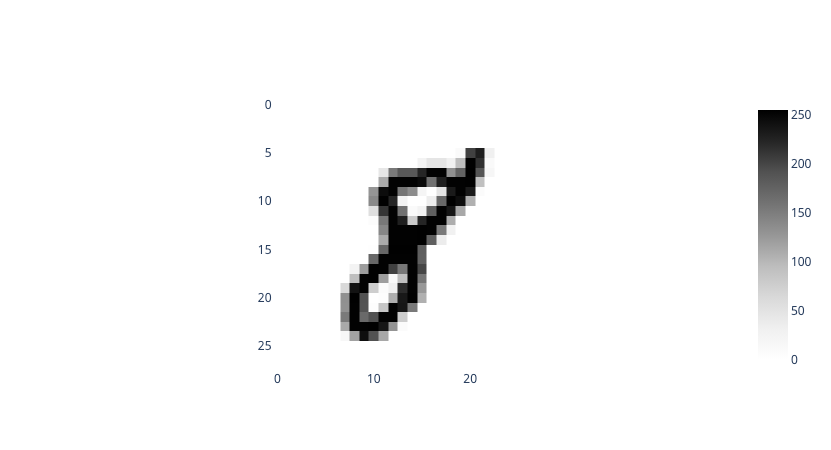

In [87]:
from gtda.plotting import plot_heatmap

image_idx = 17
some_image = X[image_idx].reshape(28, 28)
plot_heatmap(some_image)

This looks like an eight, so let's check the corresponding label:

In [88]:
y[image_idx]

'8'

The image and label match, so let's reshape the whole feature matrix and create a training and test set:

In [68]:
X = X.reshape((-1, 28, 28))

# For a full-blown example, you can set n_train, n_test = 60000, 10000
n_train, n_test = 60, 10

X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train : n_train + n_test]
y_test = y[n_train : n_train + n_test]

print(
    f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}, X_test shape: {X_test.shape}, y_test shape: {y_test.shape}"
)

X_train shape: (60, 28, 28), y_train shape: (60,), X_test shape: (10, 28, 28), y_test shape: (10,)


## From images to topological features

<div style="text-align: center">
<img src='images/example_pipeline_images.png' width='600'>
<p style="text-align: center;"> <b>Figure:</b> An example of a topological feature extraction pipeline. Figure reference: arxiv.org/abs/1910.08345 </p>
</div>

## Binarize the images

In [30]:
binarizer = Binarizer(threshold=0.4)
X_train_binarized = binarizer.fit_transform(X_train)

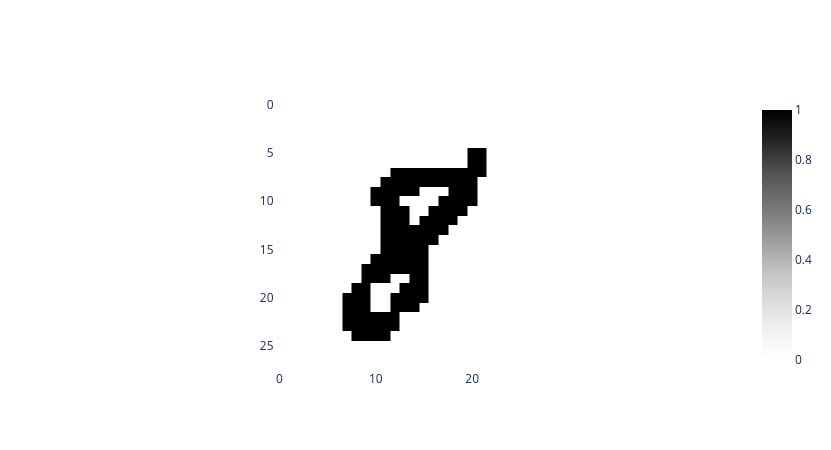

In [89]:
# NOTE TO UMBE: plot_heatmap does not support binary arrays
plot_heatmap(X_train_binarized[image_idx]*1.)

## Inverting the boolean images

In [32]:
inverter = Inverter(n_jobs=-1)
X_train_inverted = inverter.fit_transform(X_train_binarized)

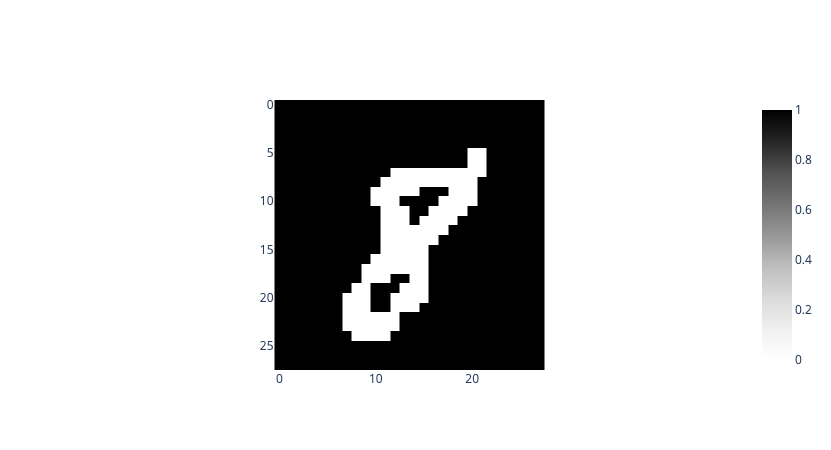

In [90]:
plot_heatmap(X_train_inverted[image_idx]*1.)

## Applying a boolean image filtration

In [37]:
n_iterations = 28

erosion_filtration = ErosionFiltration(n_iterations=n_iterations, n_jobs=-1)
X_train_filtered = erosion_filtration.fit_transform(X_train_inverted)

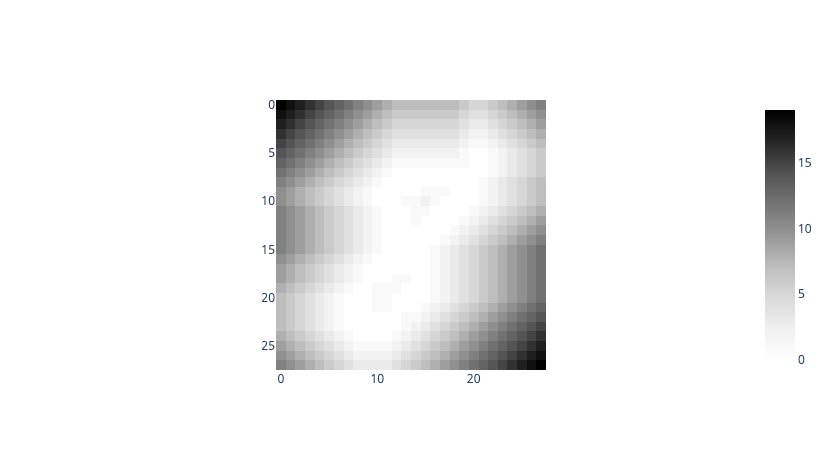

In [91]:
plot_heatmap(X_train_filtered[image_idx])

## Getting persistence diagrams out of images

In [92]:
cubical_complex = CubicalPersistence(n_jobs=-1)
X_train_cubical = cubical_complex.fit_transform(X_train_filtered)

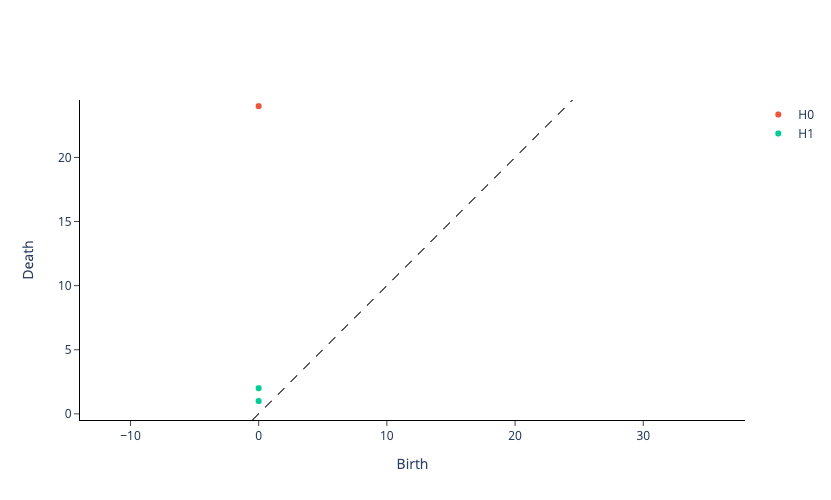

In [93]:
plot_diagram(X_train_cubical[image_idx])

## Computing the heat kernel vector representation of stacked diagrams

In [43]:
diagram_stacker = ForgetDimension()
X_train_stacked = diagram_stacker.fit_transform(X_train_cubical)

In [44]:
heat = HeatKernel(sigma=3., n_bins=36, n_jobs=-1)
X_train_heat = heat.fit_transform(X_train_stacked)

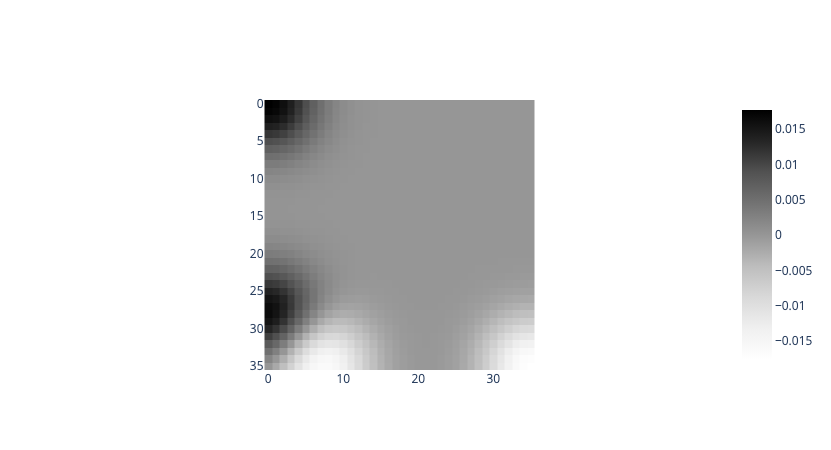

In [45]:
plot_heatmap(X_train_heat[1, 0])

In [ ]:
print(X_train_heat.shape)

## Rescaling the diagrams

In [46]:
metric = {'metric': 'bottleneck', 'metric_params': {}}

diagram_scaler = Scaler(**metric)
X_train_scaled = diagram_scaler.fit_transform(X_train_cubical)

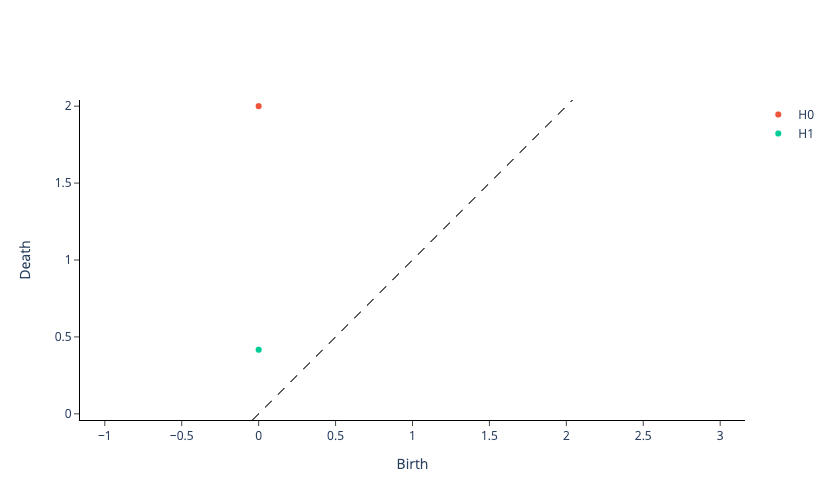

In [47]:
diagram_scaler.plot(X_train_scaled, 1)

## Building a pipeline to extract features

We can summarize all the previous step into a single giotto Pipeline pictured below:

![example_pipeline_images](images/example_pipeline_images.png "TDA pipeline for MNIST images.")

In [55]:
import numpy as np

steps = [
    ('binarizer', Binarizer(threshold=0.4)),
    ('filtration', RadialFiltration(center=np.array([20, 6]), n_jobs=-1)),
    ('diagram', CubicalPersistence(n_jobs=-1)),
    ('rescaling', Scaler()),
    ('amplitude', Amplitude(metric='wasserstein', metric_params={'p': 2}, n_jobs=-1))
]

pipeline_signed_distance = Pipeline(steps)

In [56]:
X_train_pipeline_distance = pipeline_signed_distance.fit_transform(X_train)

## Obtaining features from different filtrations

In [57]:
direction_list = [ np.array([0, 1]), np.array([0, -1]), np.array([1, 0]), np.array([-1, 0]) ]

filtration_list = [HeightFiltration(direction=direction) 
                    for direction in direction_list]

steps_list = [ [
    ('binarizer', Binarizer(threshold=0.4)),
    ('filtration', filtration),
    ('diagram', CubicalPersistence()),
    ('amplitude', Amplitude(metric='heat', metric_params={'p': 2}))]
    for filtration in filtration_list ]

pipeline_list = [ (str(direction_list[i]), Pipeline(steps_list[i])) for i in range(len(steps_list))]
feature_union_filtrations = FeatureUnion(pipeline_list, n_jobs=-1)

In [58]:
feature_union_filtrations.fit(X_train[:20])
X_train_filtrations = feature_union_filtrations.transform(X_train)

In [59]:
X_train_filtrations.shape

(60, 8)

## Deriving a full-scale TDA feature extraction pipeline

We can go full-scale and extract a large number of features by creating a full-blown pipeline such as the one below.

![diagram_pipeline_images](images/diagram_pipeline_images.png "Full-blown TDA pipeline for MNIST images.")


Careful, some of them will be highly correlated, so it would be good to use a feature selection algorithm to reduce their number before passing them to a classifier.

Note that if you have selected a large number of training/testing samples, this part will take a lot of resources to run. Consider using a cluster.

In [60]:
direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]
center_list = [
    [13, 6],
    [6, 13],
    [13, 13],
    [20, 13],
    [13, 20],
    [6, 6],
    [6, 20],
    [20, 6],
    [20, 20],
]
n_iterations_erosion_list = [6, 10]
n_iterations_dilation_list = [6, 10]
n_iterations_signed_list = [6, 10]
n_neighbors_list = [2, 4]

# Creating a list of all filtration transformer, we will be applying
filtration_list = (
    [HeightFiltration(direction=np.array(direction)) for direction in direction_list]
    + [RadialFiltration(center=np.array(center)) for center in center_list]
    + [
        ErosionFiltration(n_iterations=n_iterations)
        for n_iterations in n_iterations_erosion_list
    ]
    + [
        DilationFiltration(n_iterations=n_iterations)
        for n_iterations in n_iterations_dilation_list
    ]
    + [
        SignedDistanceFiltration(n_iterations=n_iterations)
        for n_iterations in n_iterations_signed_list
    ]
    + ["passthrough"]
)

# Creating the diagram generation pipeline
diagram_steps = [
    [
        Binarizer(threshold=0.4),
        filtration,
        CubicalPersistence(homology_dimensions=[0, 1]),
        Scaler(metric="bottleneck"),
    ]
    for filtration in filtration_list
]

# Listing all metrics we want to use to extract diagram amplitudes
metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]

#
feature_union = make_union(
    *[PersistenceEntropy()]
    + [Amplitude(**metric, order=None) for metric in metric_list]
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)

In [61]:
X_train_tda = tda_union.fit_transform(X_train)
X_train_tda.shape

(60, 672)

We have generated 672 topological features per image! Now, those features were not chosen properly and some of them are highly correlated.

We can run a hyperparameter search to find the best one! Let's do it for a simple pipeline that uses HeightFiltration and let's find the best direction for a classification problem using a RandomForestClassifier:

In [62]:
height_pipeline = Pipeline([
    ('binarizer', Binarizer(threshold=0.4)),
    ('filtration', HeightFiltration()),
    ('diagram', CubicalPersistence()),
    ('feature', PersistenceEntropy()),
    ('classifier', RandomForestClassifier())
])

We can tune features hyper parameters and classifier hyper parameters together in a single hyper parameters grid search.

In [63]:
direction_list = [ [1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1] ] 
homology_dimensions_list = [ [0], [1] ]
n_estimators_list = [ 500, 1000, 2000 ]

param_grid = {
    'filtration__direction': [np.array(direction) for direction in direction_list],
    'diagram__homology_dimensions' : [homology_dimensions for homology_dimensions in homology_dimensions_list],
    'classifier__n_estimators': [n_estimators for n_estimators in n_estimators_list]
}

grid_search = GridSearchCV(estimator=height_pipeline, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('binarizer', Binarizer(threshold=0.4)),
                                       ('filtration', HeightFiltration()),
                                       ('diagram', CubicalPersistence()),
                                       ('feature', PersistenceEntropy()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__n_estimators': [500, 1000, 2000],
                         'diagram__homology_dimensions': [[0], [1]],
                         'filtration__direction': [array([1, 0]), array([1, 1]),
                                                   array([0, 1]),
                                                   array([-1,  1]),
                                                   array([-1,  0]),
                                                   array([-1, -1]),
                                                   array([ 0, -1]),
                                                   array([ 1, -1])]})

In [64]:
print("Best parameters set found on validation set:")
print()
print(grid_search.best_params_)
print()
print("Grid scores on validation set:")
print()
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full validation set.")
print("The scores are computed on the full validation set.")
print()
y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on validation set:

{'classifier__n_estimators': 1000, 'diagram__homology_dimensions': [0], 'filtration__direction': array([1, 0])}

Grid scores on validation set:

0.283 (+/-0.125) for {'classifier__n_estimators': 500, 'diagram__homology_dimensions': [0], 'filtration__direction': array([1, 0])}
0.233 (+/-0.125) for {'classifier__n_estimators': 500, 'diagram__homology_dimensions': [0], 'filtration__direction': array([1, 1])}
0.167 (+/-0.094) for {'classifier__n_estimators': 500, 'diagram__homology_dimensions': [0], 'filtration__direction': array([0, 1])}
0.250 (+/-0.082) for {'classifier__n_estimators': 500, 'diagram__homology_dimensions': [0], 'filtration__direction': array([-1,  1])}
0.183 (+/-0.094) for {'classifier__n_estimators': 500, 'diagram__homology_dimensions': [0], 'filtration__direction': array([-1,  0])}
0.267 (+/-0.047) for {'classifier__n_estimators': 500, 'diagram__homology_dimensions': [0], 'filtration__direction': array([-1, -1])}
0.183 (+/-0

/Users/lewtun/miniconda3/envs/gtda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/lewtun/miniconda3/envs/gtda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



We have a full report on the grid search result! Even on this very small train set, HeightFiltration with direction [1, 0] in dimension 0 (connected components) provides the most promising feature! Can you interpret why?